In [154]:
# Example: Custom Layout Pass with NetworkX for VQE or GHZ optimization

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, Layout
from qiskit.transpiler import generate_preset_pass_manager
import qiskit_ibm_runtime.fake_provider as fk  # Example IBM device
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_circuit_layout
from qiskit.transpiler import Layout, CouplingMap

#  Adaptive Cyclic Layout Map (ACLM): Hardware-Aware optimization for circular TwoLocal circuits

**Overview**

This layout algorithm efficiently maps n-Qubit **TwoLocal** quantum circuits with circular entanglement onto quantum hardware. It identifies physical qubit cycles or near-cycles within the device's coupling map to align with the logical ring structure of your circuit, minimizing SWAP gates and overall depth.


**Key Use Cases**

- Variational Quantum Eigensolver (VQE) with Circular Ansatz  
- Periodic Ising Model Simulations
- Quantum Approximate Optimization Algorithm (QAOA) implementations of:  
  - 1D periodic Ising chains  
  - Circular or nearest-neighbor graph structures  
  

**Computational Advantages**

- Utilizes available physical cycles when present  
- Optionally adds ancilla qubits to complete minimal-length cycles  
- Hardware-aware, reducing gate overhead and enhancing circuit fidelity  
- Generally outperforms default: 'trivial','dense' and 'sabre' layouts for such structured problems.

**Limitations**

- The ACLM algorithm does not outperform the state-of-the art VF2++ layout mapping algorithm. However, VF2++ is extremely costly for large circuits.
- The algorithm is only optimal for TwoLocal circuits and not optimal when multiqubit gates are introduced.
 


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/1726926472.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc= RealAmplitudes(num_qubits=4,reps=1\


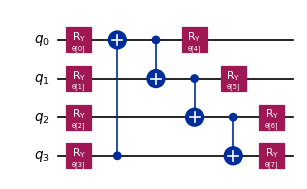

In [146]:
""" We initialize a 2-Local real Amplitude circuit,
a heuristic ansatz commonly used in Variational Quantum Eigensolver (VQE) algorithms, 
Quantum Approximate Optimization Algorithms (QAOA), and Quantum machine learning classification algorithms.

The circuit consists of a series of single-qubit rotations and entangling gates,
applied in a circular manner across the qubits: i.e.
"""

qc= RealAmplitudes(num_qubits=4,reps=1\
                   ,entanglement='circular',flatten=True);
qc.draw('mpl',scale=0.6)

Demonstration circuit: 40 qubit circuit is initialized and transpiled using a 'sabre' layout pass, in the FakeWashingtonV2() backend

The circuit Depth and CNOT gate count post transpilation is printed

The hardware layout of the Physical Qubits (numbered from 0 to n) in the backend architecture is plotted

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/1730112223.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc= RealAmplitudes(num_qubits=n,reps=1\
/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/1730112223.py:14: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


Circuit depth: 153
CNOT count: 124


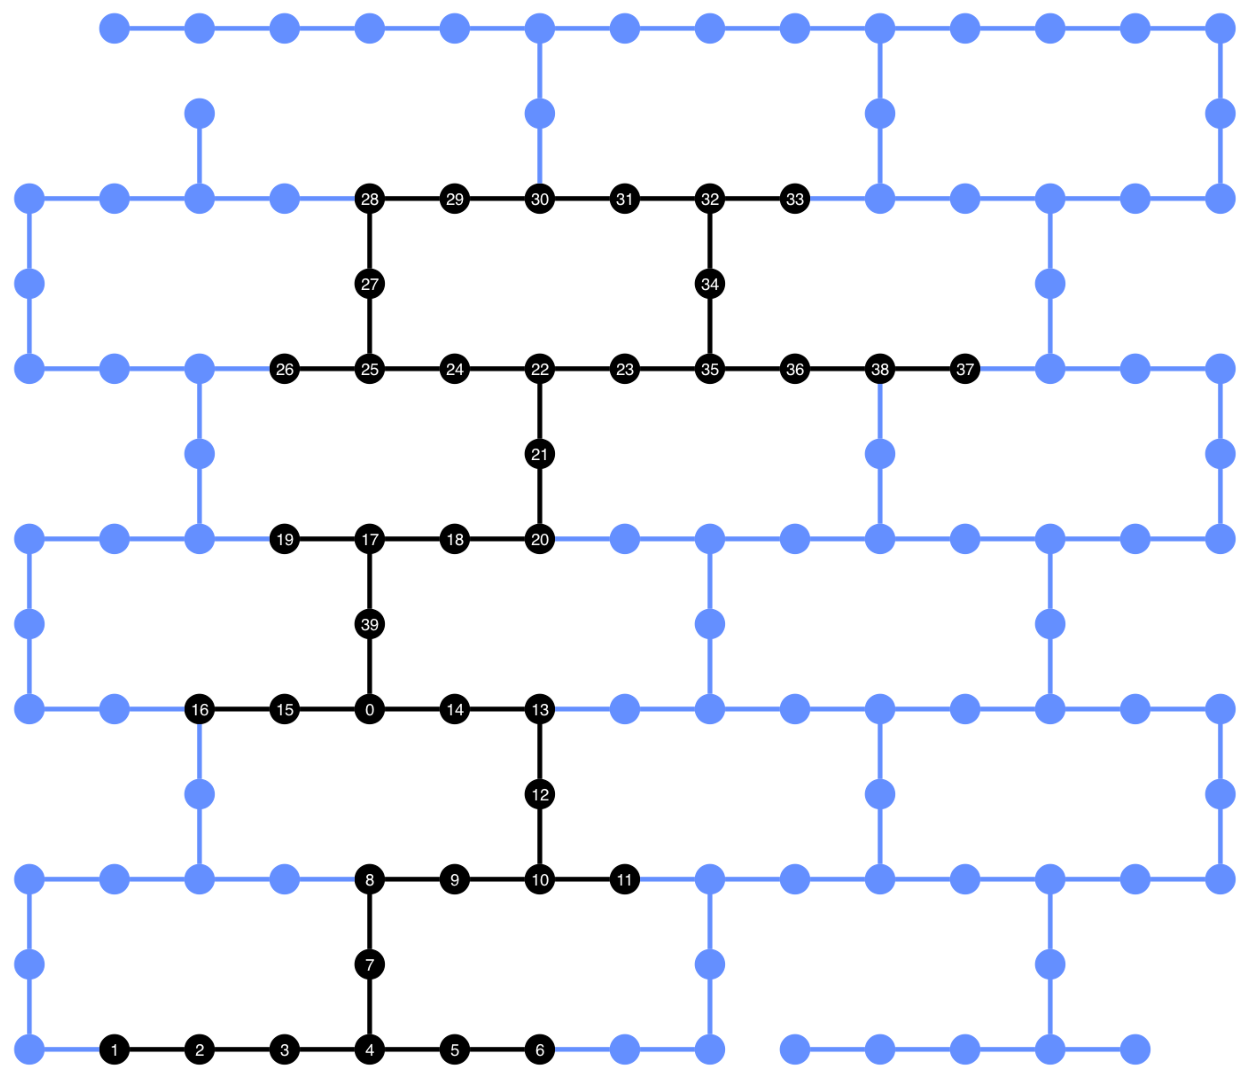

In [153]:
#number of qubits
n=40

#We use a fake backend for demonstration
backend = fk.FakeWashingtonV2() 
#coupling map of qubits for the given backend hardware
cm = CouplingMap(backend.configuration().coupling_map)

qc= RealAmplitudes(num_qubits=n,reps=1\
                   ,entanglement='circular',flatten=True)

#transpile  the circuit with a 'sabre' layout pass
#other transpiler passes like routing, scheduling etc. are system default
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='sabre',
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc)

print("Circuit depth:",transpiled_circ.depth())
print("CNOT count:",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend )



**The ACLM layout pass**
For a given hardware, Logical qubits are mapped to physical qubits in a cyclic order.
- Uses the Networkx python package to represent the coupling map (for a given backend hardware) as a graph, and then finds the set simple cycles in the graph
- For a given circuit with n-qubits, we try to obtain a cycle with length n
- If an exact cycle of length n is not possible in the hardware, we take the next largest cycle and use the required ancillas. 
- This can suggest harware aware optimal circuit ansatz for VQE

In [155]:


def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Finds an exact cycle of length n, else return the nearest larger cycle.
    Inputs:
        coupling_map: CouplingMap object representing the hardware connectivity
        n: Desired cycle length
    Returns:
        A cycle of length n if found, otherwise the smallest larger cycle, or None if no cycles exist.
    """
    #Convert CouplingMap to NetworkX graph
    G = nx.Graph()

    #Add edges from the coupling map to the NetwrkX graph object
    G.add_edges_from(coupling_map.get_edges())

    #Find all simple cycles in the graph
    cycles = list(nx.simple_cycles(G))

    #cycles with desired length n
    exact = [c for c in cycles if len(c) == n]
    #cycles with length larger than n
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):

    """
    Adaptive layout for ring circuits: suggests ancilla qubits if needed
    Inputs: 
        logical_qubits: Number of logical qubits in the circuit
        coupling_map: CouplingMap object representing the hardware connectivity

    Returns:
        required_qubits: Total number of qubits needed (logical + ancilla)
        ancilla: Number of ancilla qubits required (if any)

    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits


    return required_qubits, ancilla



For each hardware backen, exact cyclic sub-graphs can be made only for certain qubit numbers.

However, one can add ancillas qubits till we reach such a number. We see that such a mapping almost always outperforms 'trivial' and 'sabre' methods

Logical qubits: 40, Total needed: 40, Ancilla: 0


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/3455666409.py:11: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc_cyclic= RealAmplitudes(num_qubits=required_qubits,reps=1\
/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/3455666409.py:22: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


Circuit depth 48
CNOT count 40


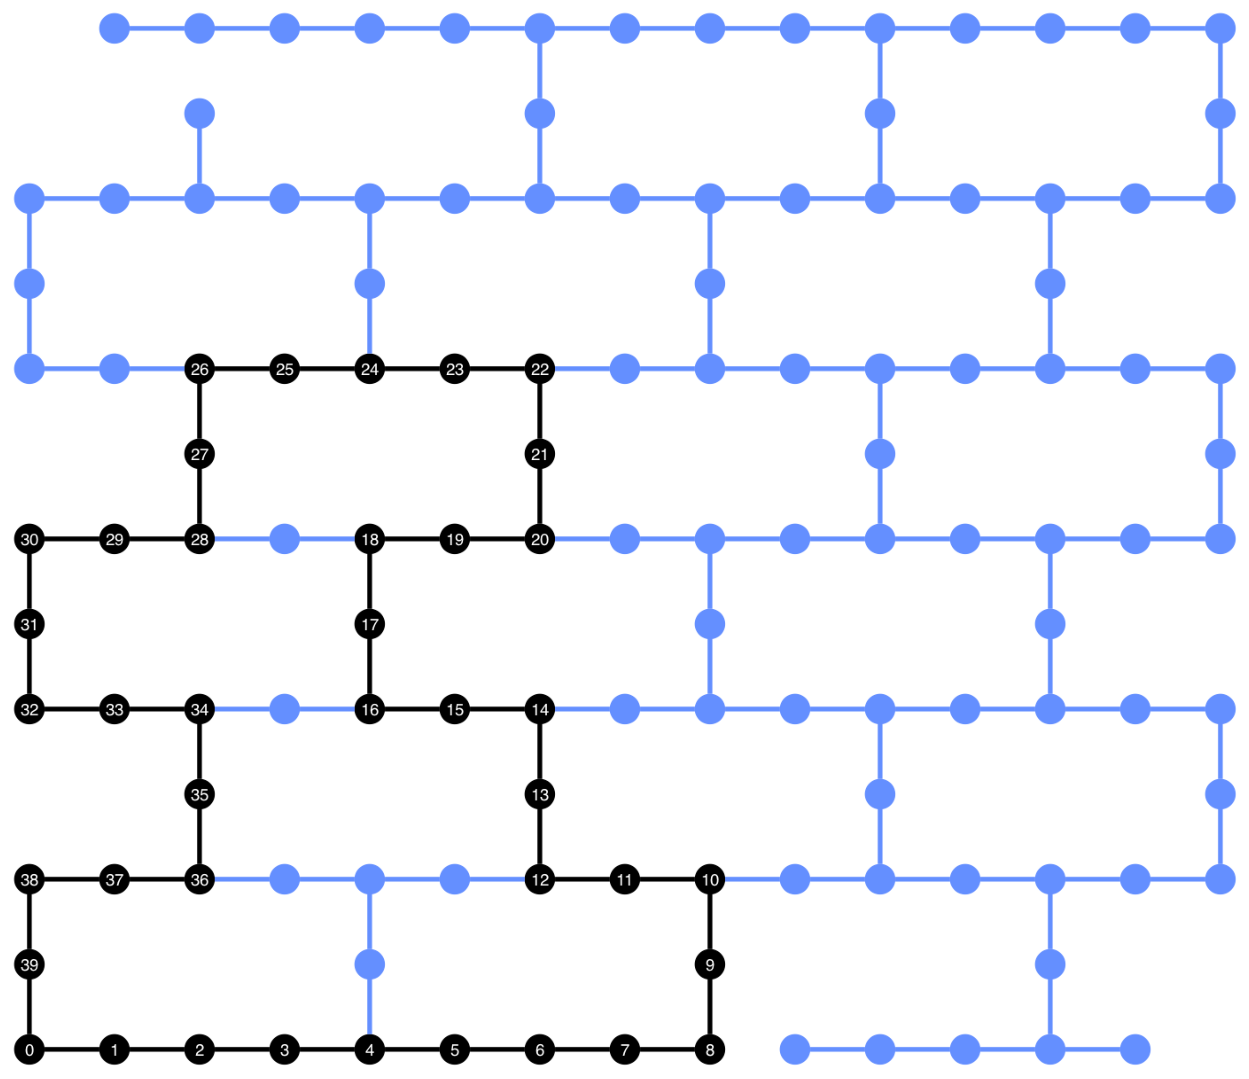

In [157]:
#n=60
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

#Determine layout and qubits
required_qubits, ancilla_count = adaptive_ring_layout(n, cm)
print(f"Logical qubits: {n}, Total needed: {required_qubits}, Ancilla: {ancilla_count}")


#Defines the circuit
qc_cyclic= RealAmplitudes(num_qubits=required_qubits,reps=1\
                   ,entanglement='circular',flatten=True)

#Obtain cycle-graph with circuit+ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

# Create a layout dictionary mapping qubits to cycle positions
layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
layout_cyclic = Layout(layout_dict)

# Transpile the circuit with the custom layout
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        coupling_map=cm)
# Run the pass manager on the circuit
transpiled_circ = pass_manager.run(qc_cyclic)

print("Circuit depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)

**Approximate ACLM: for cases when an ancilla is undesired**

Incase of simulating periodic Hamiltonians (periodic Ising chain using QAOA for example), adding further ancilla qubits will change the cost Hamiltonian.

However, one can still find the smallest cyclic sub-graph that is larger than the given circuit and then choose to perform the map it partially, like a *partial-wrap-around*.

Such an approach will minimize the distance between the first and last qubits, reducing the SWAP gate overhead.

**Approximate ACLM for QAOA**

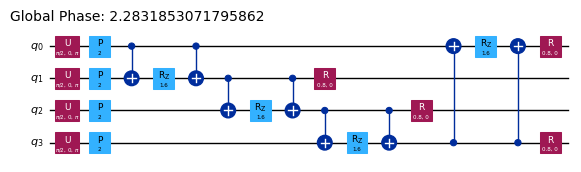

In [162]:

def qaoa_ising_periodic(n, gamma, beta,h=1):
    """
    Example QAOA Circuit for a simple Periodic Ising Chain
    Inputs:
        n: Number of qubits (logical qubits)
        gamma: Parameter for ZZ interaction
        beta: Parameter for X rotation
        h: Parameter for Z rotation
    Returns:
        QuantumCircuit object representing the QAOA circuit
    """
    qc = QuantumCircuit(n)

    #Initial Hadamard layer
    qc.h(range(n))

    #Cost layer (Z terms)
    for i in range(n):
        qc.rz(2 * h, i)  # Apply Z rotation for each qubit

    #Cost layer (ZZ terms) with periodic boundary conditions
    for i in range(n):
        qc.rzz(2 * gamma, i, (i + 1) % n)

     # Mixer layer (X rotations)
    for i in range(n):
        qc.rx(2 * beta, i)

    return qc



# Example ising chain parameters
n = 4  # Logical problem size
gamma = 0.8
beta = 0.4

# Create QAOA for the given ising chain Circuit
qc = qaoa_ising_periodic(n, gamma, beta).decompose()
qc.draw('mpl',scale=0.5)

Logical qubits: 42, minimum largest needed for a circle:       44, Ancilla: 2


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/1159136363.py:25: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


Circuit depth 137
CNOT count 90


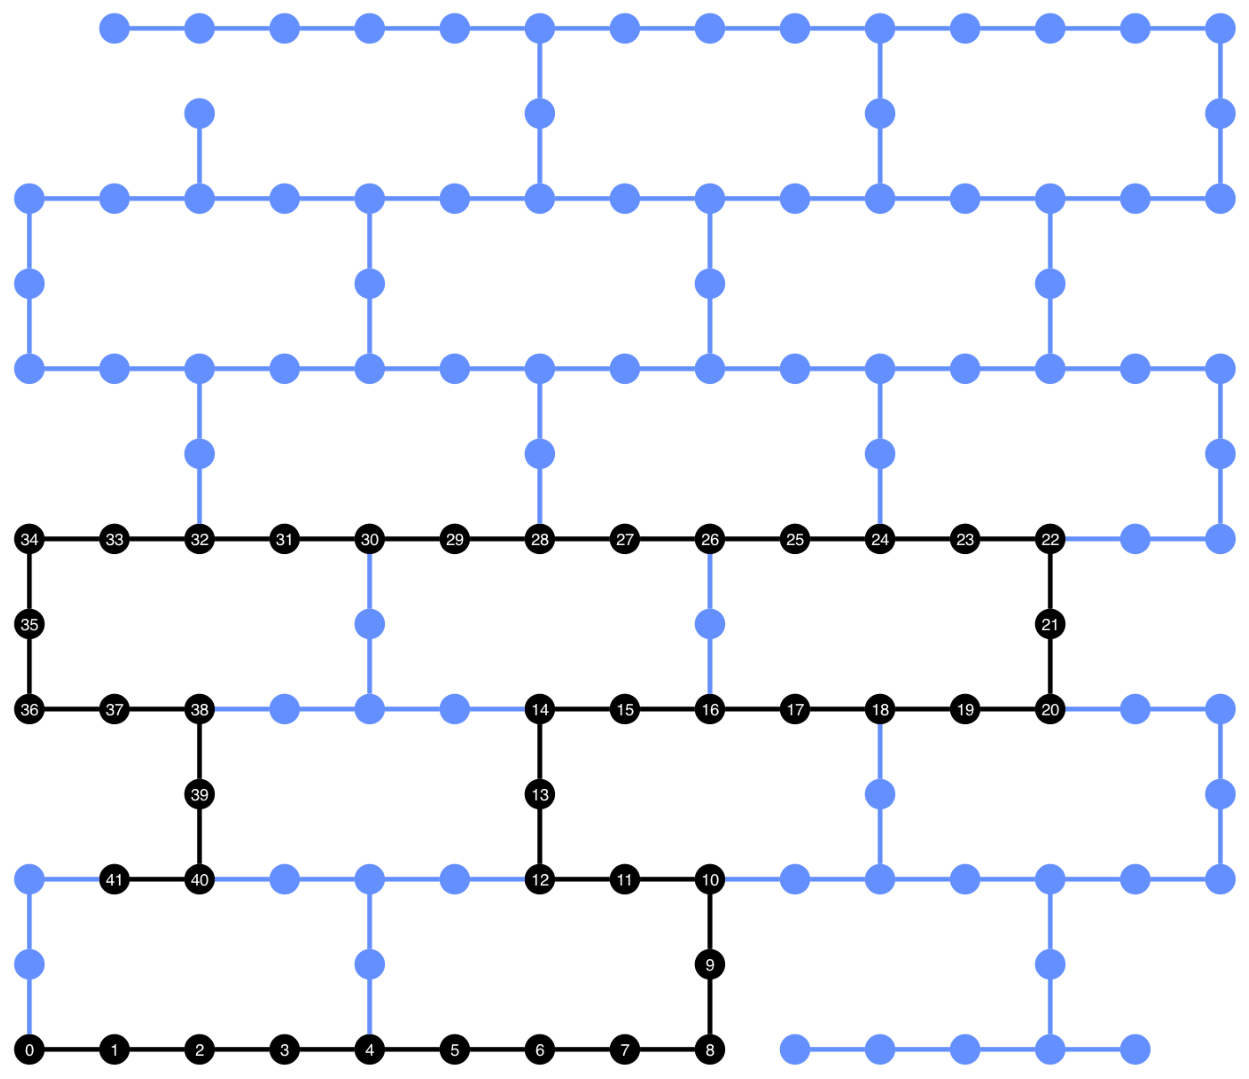

In [170]:
# We use a fake backend for demonstration
backend = fk.FakeWashingtonV2()
# Coupling map of qubits for the given backend hardware
cm = CouplingMap(backend.configuration().coupling_map)


#The quantum circuit for the QAOA is defined
#Example ising chain parameters
n = 42  # Logical problem size
gamma = 0.8
beta = 0.4
qc_qaoa= qaoa_ising_periodic(n, gamma, beta).decompose()

#Determine layout and qubits
required_qubits, ancilla_count = adaptive_ring_layout(n, cm)
print(f"Logical qubits: {n}, minimum largest needed for a circle:\
       {required_qubits}, Ancilla: {ancilla_count}")

#obtain cycle-graph with circuit+ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

#Map only till n (number of logical qubits), not the total qubits with ancilla
layout_dict = {qc_qaoa.qubits[i]: cycle[i] for i in range(n)}
layout_qaoa = Layout(layout_dict)
pass_manager = generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        initial_layout=layout_qaoa,
        coupling_map=cm)
    
transpiled_circ_qaoa = pass_manager.run(qc_qaoa)

print("Circuit depth",transpiled_circ_qaoa.depth())
print("CNOT count",transpiled_circ_qaoa.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ_qaoa, backend)


See below the same QAOA circuit, transpiled using the 'sabre' layout pass. One notices the clear performance boost offered by Approximate ACLM

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/314084124.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


Circuit depth 214
CNOT count 140


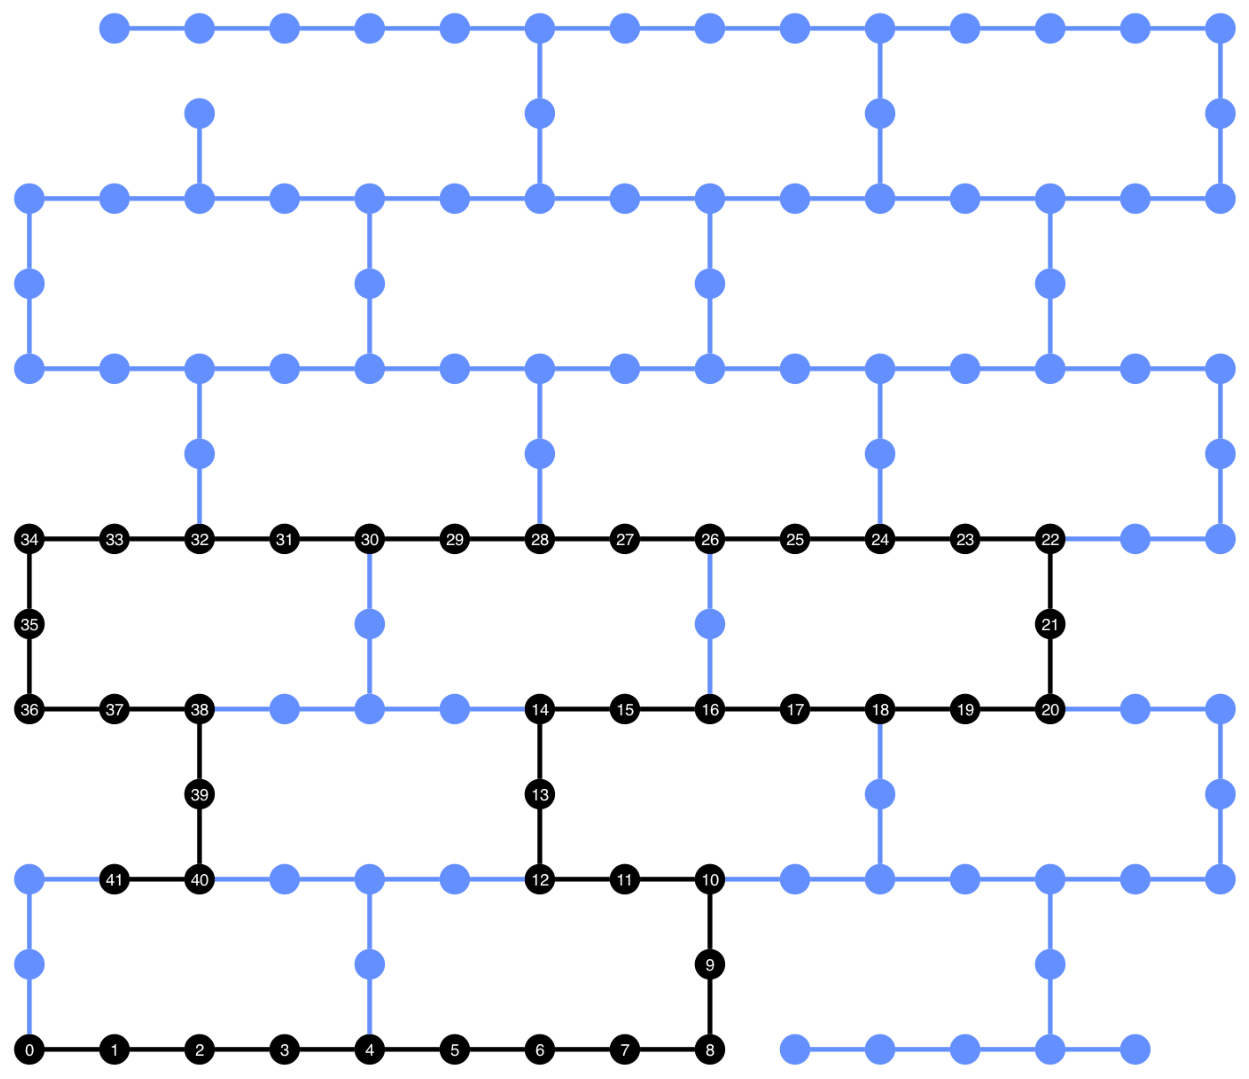

In [172]:
pass_manager = generate_preset_pass_manager(
        optimization_level=3,
        backend=backend,
        layout_method='sabre',
        coupling_map=cm)
    
qaoa_sabre = pass_manager.run(qc_qaoa)

print("Circuit depth",qaoa_sabre.depth())
print("CNOT count",qaoa_sabre.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ_qaoa, backend)

